In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Analyze each frame of a video for cars using a pretrained Neural Net

In [2]:
from keras.models import load_model
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
import pdb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label as scipyLabel

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model = load_model('model.h5')

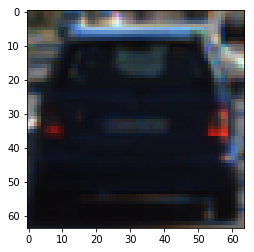

In [4]:
filename = './data/vehicles/3.png'
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [5]:
float(model.predict(image[None, :, :, :], batch_size=1))

0.980944037437439

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
window_dim = 50
class BigRect:
    def __init__(self, window): # Window is in ((startx, starty), (endx, endy)) form
        self.top_left = list(window[0])
        self.bottom_right = list(window[1])

    def add_rect(self, window):
        """Update the Big Rectangle Dimensions to include the small window"""
        self.top_left[0] = min(self.top_left[0], window[0][0])
        self.top_left[1] = min(self.top_left[1], window[0][1])
        self.bottom_right[0] = max(self.bottom_right[0], window[1][0])
        self.bottom_right[1] = max(self.bottom_right[1], window[1][1])
    
    def is_touching(self, window):
        """Determine if a sliding window should be added to the Big Rectangle"""
        tmp_TL = [o-window_dim*0.7 for o in self.top_left]
        tmp_BR = [o+window_dim*0.7 for o in self.bottom_right]
        dx = min(self.bottom_right[0], window[1][0]) - max(self.top_left[0], window[0][0]) # Thanks stackoverflow
        dy = min(self.bottom_right[1], window[1][1]) - max(self.top_left[1], window[0][1])
        if (dx>=0) and (dy>=0):
            return True
        return False 

In [14]:
def search_windows(img, windows):
    big_rects = []
    for window in windows:
        small_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        label = float(model.predict(small_img[None, :, :, :], batch_size=1))
        if label > 0.7:
            for big_rect in big_rects:
                if big_rect.is_touching(window):
                    big_rect.add_rect(window)
                    break
            else:
                big_rects.append(BigRect(window))
    return big_rects

# def only_unique_big_rects(big_rects):
#     """Takes a list of type BigRect and merges any that are overlapping"""
#     for o_rect in big_rects:
#         for i_rect in big_rects:
#             tmp_window = (i_rect.top_left, i_rect.bottom_right)
#             if o_rect.is_touching(tmp_window):
#                 o_rect.add_rect(tmp_window)
#                 big_rects.remove(i_rect)
#     return big_rects

def add_heat(heatmap, prev_frames):    
    for frame in prev_frames:
        for big_rect in frame:
            box = (big_rect.top_left, big_rect.bottom_right)
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [35]:
h = 720
w = 1280
HIST_LEN = 5
HEAT_THRESH = 3
prev_big_rects = []
image = None
def process_image(img):
#     plt.imsave('test.png', img)
#     pdb.set_trace()
    windows = []
    windows += slide_window(img, (int(w*.6), w), (int(h*.5), int(h*.9)), xy_window=(window_dim,window_dim))
    big_rects = search_windows(img, windows)
#     big_rects = only_unique_big_rects(big_rects)
    
    # Update the history
    prev_big_rects.append(big_rects) # List of lists
    if len(prev_big_rects) > HIST_LEN: prev_big_rects.pop(0)
    
    # Create a heatmap over time to smooth the video
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, prev_big_rects)
    heat = apply_threshold(heat, HEAT_THRESH)
    heatmap = np.clip(heat, 0, 255)
    labels = scipyLabel(heatmap)
    img_with_cars = draw_labeled_bboxes(np.copy(img), labels)

    
#     bboxes = [(tuple(r.top_left), tuple(r.bottom_right)) for r in big_rects]
#     img_with_cars = draw_boxes(img, bboxes)
#     pdb.set_trace()
    return img_with_cars

In [36]:
prev_big_rects = []

output_file = 'output_images/video.mp4'
input_clip = VideoFileClip('project_video.mp4').subclip(27,30) # Subclip
# input_clip = VideoFileClip('project_video.mp4') # Full video
output_clip = input_clip.fl_image(process_image) # NOTE: this function expects color images
%time output_clip.write_videofile(output_file, audio=False)

input_clip.reader.close()
input_clip.audio.reader.close_proc()

output_clip.reader.close()
output_clip.audio.reader.close_proc()

del input_clip
del output_clip

[MoviePy] >>>> Building video output_images/video.mp4
[MoviePy] Writing video output_images/video.mp4


 99%|█████████▊| 75/76 [00:33<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video.mp4 

CPU times: user 43.1 s, sys: 2.98 s, total: 46 s
Wall time: 34.4 s
